# Getting started with DataJoint

Now that you have successfully connected to DataJoint (if not, please visit [Connecting to DataBase](00-ConnectingToDatabase.ipynb) first), let's dive into using DataJoint! In this notebook, we will:

1. learn what a data pipeline is
2. create our first simple data pipeline in DataJoint
3. insert some data into the pipeline
4. basic queries to flexible explore the data pipeline
5. fetch the data from the pipeline
6. delete entries from tables

As always, let's start by importing the `datajoint` library.

In [1]:
import datajoint as dj

# So... What is a data pipeline?

If you visit the [documentation for DataJoint](https://docs.datajoint.io/introduction/Data-pipelines.html), we define a data pipeline as follows:
> A data pipeline is a sequence of steps (more generally a directed acyclic graph) with integrated storage at each step. These steps may be thought of as nodes in a graph.

While this is an accurate description, it may not be the most intuitive definition. Put succinctly, a data pipeline is a listing or a "map" of various "things" that you work with in a project, with line connecting things to each other to indicate their dependencies. The "things" in a data pipeline tends to be the *nouns* you find when describing a project. The "things" may include anything from mouse, experimenter, equipment, to experiment session, trial, two-photon scans, electric activities, to receptive fields, neuronal spikes, to figures for a publication! A data pipeline gives you a framework to:

1. define these "things" as tables in which you can store the information about them
2. define the relationships (in particular the dependencies) between the "things"

A data pipeline can then serve as a map that describes everything that goes on in your experiment, capturing what is collected, what is processed, and what is analyzed/computed. A well designed data pipeline not only let's you organize your data well, but can bring out logical clarity to your experiment, and may even bring about new insights by making how everything in your experiment relates together obvious.

Let's go ahead and build together a pipeline from scratch to better understand what a data pipeline is all about.

# Building our first pipeline: 

Let's build a pipeline to collect, store and process data and analysis for our hypothetical single electrode recording or calcium imaging recording in mice. To help us understand the project better, here is a brief description:

> * Your lab houses many mice, and each mouse is identified by a unique ID. You also want to keep track of information about each mouse such as their date of birth, and gender.
> * As a hard working neuroscientist, you perform experiments every day, sometimes working with more than one mouse in a day! However, on an any given day, a mouse undergoes at most one recording session.
> * For each experimental session, you would like to record what mouse you worked with and when you performed the experiment. You would also like to keep track of other helpful information such as the experimental setup you worked on.  

> * In a session of electrophysiology
>> * you record electrical activity from a single neuron. You use recording equipment that produces separate data files for each neuron you recorded.
>> * Neuron's activities are recorded as raw traces. Neuron's spikes needs to be detected for further analysis to be performed.
> * In a session of calcium imaging
>> * you scan a brain region containing a number of neurons. You use recording equipment that produces separate data files for each scan you performed.
>> * you would like to segment the frames and get the regions of interest (ROIs), and save a mask for each ROI
>> * finally you would like to extract the trace from each segmented ROI

Pipeline design starts by identifying **things** or **entities** in your project. Common entities includes experimental subjects (e.g. mouse), recording sessions, and two-photon scans.

Let's revisit the project description, this time paying special attention to **what** (e.g. nouns) about your experiment. Here I have highlighted some nouns in particular.

> * Your lab houses many **mice**, and each mouse is identified by a unique ID. You also want to keep track of information about each mouse such as their date of birth, and gender.
> * As a hard working neuroscientist, you perform experiments every day, sometimes working with more than one mouse in a day! However, on an any given day, a mouse undergoes at most one recording session.
> * For each **experimental session**, you would like to record what mouse you worked with and when you performed the experiment. You would also like to keep track of other helpful information such as the experimental setup you worked on.  

> * In a session of electrophysiology
>> * you record electrical activity from a **single neuron**. You use recording equipment that produces separate data files for each neuron you recorded.
>> * Neuron's activities are recorded as raw traces. **Neuron's spikes** needs to be detected for further analysis to be performed.
> * In a session of calcium imaging
>> * you scan a brain region containing a number of neurons. You use recording equipment that produces separate data files for each **scan** you performed.
>> * you would like to segment the frames and get the **regions of interest (ROIs)**, and save a mask for each ROI
>> * finally you would like to extract the **trace** from each segmented ROI

Just by going though the description, we can start to identify **things** or **entities** that we might want to store and represent in our data pipeline:

* mouse
* experimental session

For ephys:

>* neuron
>* spikes

For calcium imaging:

>* scan
>* regions of interest
>* trace

In the current notebook, we will design the tables for mouse and experimental sessions, the rest of the pipeline will be designed in the subdirectory `electrophysioloy` and `calcium_imaging`

In DataJoint data pipeline, we represent these **entities** as **tables**. Different *kinds* of entities become distinct tables, and each row of the table is a single example (instance) of the category of entity. 

For example, if we have a `Mouse` table, then each row in the mouse table represents a single mouse!

When constructing such table, we need to figure out what it would take to **uniquely identify** each entry. Let's take the example of the **mouse** and think about what it would take to uniquely identify a mouse.

After some thought, we might conclude that each mouse can be uniquely identified by knowing its **mouse ID** - a unique ID number assigned to each mouse in the lab. The mouse ID is then a column in the table or an **attribute** that can be used to **uniquely identify** each mouse. Such attribute is called the **primary key** of the table.

| mouse_id* |
|:--------:|
| 11234    |
| 11432    |

Once we have successfully identified the primary key of the table, we can now think about what other columns, or **non-primary key attributes** that we would want to include in the table. These are additional information **about each entry in the table that we want to store**.

For the case of mouse, what other information about the mouse you might want to store? Based on the project description, we would probably want to store information such as the mouse's **date of birth** and **gender**.

| mouse_id* | dob        | sex |
|:--------:|------------|--------|
| 11234    | 2017-11-17 | M      |
| 11432    | 2018-03-04 | F      |

Now we have an idea on how to represent information about mouse, let's create the table using **DataJoint**!

## Create a schema - house for your tables

Every table lives inside a schema - a logical collection of one or more tables in your pipeline. Your final pipeline may consists of many tables spread across one or more schemas. Let's go ahead and create the first schema to house our table.

We create the schema using `dj.schema()` function, passing in the name of the schema. For this workshop, you are given the database privilege to use any schema name.  Let's create a schema called `tutorial`.

In [2]:
schema = dj.schema("tutorial")

Connecting shan@workshop-db.datajoint.io:3306


Now that we have a schema to place our table into, let's go ahead and define our first table!

## Creating your first table

In DataJoint, you define each table as a class, and provide the table definition (e.g. attribute definitions) as the `definition` static string property. The class will inherit from the `dj.Manual` class provided by DataJoint (more on this later).

In [3]:
@schema
class Mouse(dj.Manual):
    definition = """
    # Experimental animals
    mouse_id             : int                          # Unique animal ID
    ---
    dob=null             : date                         # date of birth
    sex="unknown"        : enum('M','F','unknown')      # sex
    """

Let's take a look at our brand new table

In [4]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex


## Insert entries with `insert1` and `insert` methods

The table was successfully defined, but without any content, the table is not too interesting. Let's go ahead and insert some **mouse** into the table, one at a time using the `insert1` method.

Let's insert a mouse with the following information:
* mouse_id: 0
* date of birth: 2017-03-01
* sex: male

In [5]:
Mouse.insert1((0, "2017-03-01", "M"))

In [6]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M


You could also insert1 as a dictionary

In [7]:
data = {"mouse_id": 100, "dob": "2017-05-12", "sex": "F"}

In [8]:
Mouse.insert1(data)

In [9]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
100,2017-05-12,F


We can also insert multiple **mice** together using the `insert` method, passing in a list of data.

In [10]:
data = [(1, "2016-11-19", "M"), (2, "2016-11-20", "unknown"), (5, "2016-12-25", "F")]

In [11]:
Mouse.insert(data)

Of course, you can insert a list of dictionaries

In [12]:
data = [
    {"mouse_id": 10, "dob": "2017-01-01", "sex": "F"},
    {"mouse_id": 11, "dob": "2017-01-03", "sex": "F"},
]

# insert them all
Mouse.insert(data)

In [13]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
1,2016-11-19,M
2,2016-11-20,unknown
5,2016-12-25,F
10,2017-01-01,F
11,2017-01-03,F
100,2017-05-12,F


## Data integrity

DataJoint checks for data integrity, and ensures that you don't insert a duplicate by mistake. Let's try inserting another mouse with `mouse_id: 0` and see what happens!

In [14]:
Mouse.insert1(
    {
        "mouse_id": 0,
        "dob": "2018-01-01",
        "sex": "M",
    }
)

DuplicateError: ("Duplicate entry '0' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

Go ahead and insert a few more mice into your table before moving on.

In [15]:
data = [
    {"mouse_id": 12, "dob": "2017-03-21", "sex": "F"},
    {"mouse_id": 18, "dob": "2017-05-01", "sex": "F"},
    {"mouse_id": 19, "dob": "2018-07-21", "sex": "M"},
    {"mouse_id": 22, "dob": "2019-12-15", "sex": "F"},
    {"mouse_id": 34, "dob": "2018-09-22", "sex": "M"},
]

# insert them all
Mouse.insert(data)

In [16]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
1,2016-11-19,M
2,2016-11-20,unknown
5,2016-12-25,F
10,2017-01-01,F
11,2017-01-03,F
12,2017-03-21,F
18,2017-05-01,F
19,2018-07-21,M
22,2019-12-15,F


In [ ]:
# ENTER YOUR CODE - Insert more mice

## Create tables with dependencies

Congratulations! We have successfully created your first table! We are now ready to tackle and include other **entities** in the project into our data pipeline. 

Let's now take a look at representing an **experimental session**.

As with mouse, we should think about **what information (i.e. attributes) is needed to uniquely identify an experimental session**. Here is the relevant section of the project description:

> * As a hard working neuroscientist, you perform experiments every day, sometimes working with **more than one mouse in a day**! However, on an any given day, **a mouse undergoes at most one recording session**.
> * For each experimental session, you would like to record **what mouse you worked with** and **when you performed the experiment**. You would also like to keep track of other helpful information such as the **experimental setup** you worked on.

Based on the above, it appears that you need to know:

* the date of the session
* the mouse you recorded from in that session

to uniquely identify a single experimental session.

Note that, to uniquely identify an experimental session (or simply a **session**), we need to know the mouse that the session was about. In other words, a session cannot existing without a corresponding mouse! 

With **mouse** already represented as a table in our pipeline, we say that the session **depends on** the mouse! We could graphically represent this in an **entity relationship diagram (ERD)** by drawing the line between two tables, with the one below (**session**) depending on the one above (**mouse**).

Thus we will need both **mouse** and a new attribute **session_date** to uniquely identify a single session. 

Remember that a **mouse** is already uniquely identified by its primary key - **mouse_id**. In DataJoint, you can declare that **session** depends on the mouse, and DataJoint will automatically include the mouse's primary key (`mouse_id`) as part of the session's primary key, along side any additional attribute(s) you specify.

In [36]:
@schema
class Session(dj.Manual):
    definition = """
    # Experiment session
    -> Mouse
    session_date               : date                         # date
    ---
    experiment_setup           : int                          # experiment setup ID
    experimenter               : varchar(100)                 # experimenter name
    data_path=''               : varchar(255)                 #
    """

You can actually generate something similar to an entity relationship diagram (ERD) on the fly by calling `dj.Diagram` with the schema object. Many of the symbols and features are the same as the ERD standard.

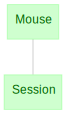

In [18]:
dj.Diagram(schema)

Let's try inserting a few sessions manually.

In [19]:
data = {
    "mouse_id": 0,
    "session_date": "2017-05-15",
    "experiment_setup": 0,
    "experimenter": "Edgar Y. Walker",
}

Session.insert1(data)

In [20]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2017-05-15,0,Edgar Y. Walker,


Let's insert another session for `mouse_id = 0` but on a different date.

In [21]:
data = {
    "mouse_id": 0,
    "session_date": "2018-01-15",
    "experiment_setup": 100,
    "experimenter": "Jacob Reimer",
}

Session.insert1(data)

Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2017-05-15,0,Edgar Y. Walker,
0,2018-01-15,100,Jacob Reimer,


And another session done on the same date but on a different mouse

In [22]:
data = {
    "mouse_id": 18,
    "session_date": "2018-01-15",
    "experiment_setup": 101,
    "experimenter": "Jacob Reimer",
}

# insert them all
Session.insert1(data)

In [23]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2017-05-15,0,Edgar Y. Walker,
0,2018-01-15,100,Jacob Reimer,
18,2018-01-15,101,Jacob Reimer,


What happens if we try to insert a session for a mouse that doesn't exist?

In [24]:
bad_data = {
    "mouse_id": 9999,  # this mouse doesn't exist!
    "session_date": "2017-05-15",
    "experiment_setup": 0,
    "experimenter": "Edgar Y. Walker",
}

In [25]:
Session.insert1(bad_data)

IntegrityError: Cannot add or update a child row: a foreign key constraint fails (`shan_tutorial`.`session`, CONSTRAINT `session_ibfk_1` FOREIGN KEY (`mouse_id`) REFERENCES `mouse` (`mouse_id`) ON UPDATE CASCADE)

# Querying data

Often times, you don't want all data but rather work with **a subset of entities** matching specific criteria. Rather than fetching the whole data and writing your own parser, it is far more efficient to narrow your data to the subset before fetching.

For this, DataJoint offers very powerful yet intuitive **querying** syntax that let's you select exactly the data you want before you fetch it.

It is also critical to note that the result of any DataJoint query represents a valid entity.

We will introduce three major types of queries used in DataJoint:
* restriction (`&`) and negative restriction (`-`): filter data
* join (`*`): bring fields from different tables together
* projection (`.proj()`): focus on a subset of attributes
* aggregation (`.aggr()`): simple computation of one table against another table

## Restrictions (`&`) - filter data with certain conditions

The **restriction** operation, `&`, let's you specify the criteria to narrow down the table on the left.

### Exact match

Mouse with id 0

In [27]:
Mouse & "mouse_id = 0"

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M


All male mice (`'sex = "M"'`)

In [28]:
Mouse & 'sex = "M"'

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
1,2016-11-19,M
19,2018-07-21,M
34,2018-09-22,M


All female mice (`'sex="F"'`)

In [29]:
Mouse & 'sex = "F"'

mouse_id Unique animal ID,dob date of birth,sex sex
5,2016-12-25,F
10,2017-01-01,F
11,2017-01-03,F
12,2017-03-21,F
18,2017-05-01,F
22,2019-12-15,F
100,2017-05-12,F


We can also use as a dictionary as a restrictor, with one field or multiple fields

In [35]:
Mouse & dict(mouse_id=5)

mouse_id Unique animal ID,dob date of birth,sex sex
5,2016-12-25,F


### Inequality

You can also use inequality in your query to match based on numerical values.

Mouse that is born **after 2017-01-01**

In [30]:
Mouse & 'dob > "2017-01-01"'

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
11,2017-01-03,F
12,2017-03-21,F
18,2017-05-01,F
19,2018-07-21,M
22,2019-12-15,F
34,2018-09-22,M
100,2017-05-12,F


Mouse that is born within a range of dates

In [31]:
Mouse & 'dob between "2017-03-01" and "2017-08-23"'

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
12,2017-03-21,F
18,2017-05-01,F
100,2017-05-12,F


Mouse that is **not** male

In [32]:
Mouse & 'sex != "M"'

mouse_id Unique animal ID,dob date of birth,sex sex
2,2016-11-20,unknown
5,2016-12-25,F
10,2017-01-01,F
11,2017-01-03,F
12,2017-03-21,F
18,2017-05-01,F
22,2019-12-15,F
100,2017-05-12,F


You can easily combine multiple restrictions to narrow down the entities based on multiple attributes.

Let's find all mouse that **is not male** AND **born after 2017-01-01**.

In [33]:
Mouse & 'sex != "M"' & 'dob > "2017-01-01"'

mouse_id Unique animal ID,dob date of birth,sex sex
11,2017-01-03,F
12,2017-03-21,F
18,2017-05-01,F
22,2019-12-15,F
100,2017-05-12,F


In [38]:
Mouse & 'sex != "M" and dob > "2017-01-01"'

mouse_id Unique animal ID,dob date of birth,sex sex
11,2017-01-03,F
12,2017-03-21,F
18,2017-05-01,F
22,2019-12-15,F
100,2017-05-12,F


Result of one query can be used in another query! Let's first find **all female mice** and store the result.

In [39]:
female_mice = Mouse & 'sex = "F"'
female_mice

mouse_id Unique animal ID,dob date of birth,sex sex
5,2016-12-25,F
10,2017-01-01,F
11,2017-01-03,F
12,2017-03-21,F
18,2017-05-01,F
22,2019-12-15,F
100,2017-05-12,F


and among these mice, find ones with **mouse_id > 10**

In [40]:
female_mice & "mouse_id > 10"

mouse_id Unique animal ID,dob date of birth,sex sex
11,2017-01-03,F
12,2017-03-21,F
18,2017-05-01,F
22,2019-12-15,F
100,2017-05-12,F


In computer science/math lingo, DataJoint operations are said to **satisfy closure property**. Practically speaking, this means that the result of a query can immediately be used in another query, allowing you to build more complex queries from simpler ones. 

### Restriction one table with another

All mice that has a session

In [38]:
Mouse & Session

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
18,2017-05-01,F


### Combining restrictions

All the above queries could be combined 

Male mice that had a session

In [43]:
Mouse & Session & 'sex = "M"'

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M


Give me all mice that have had an experimental session done on or before 2017-05-19

In [39]:
Mouse & (Session & 'session_date <= "2017-05-19"')

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M


### Negative restriction - with the `-` operator

All mice that do not have any session

In [40]:
Mouse - Session

mouse_id Unique animal ID,dob date of birth,sex sex
1,2016-11-19,M
2,2016-11-20,unknown
5,2016-12-25,F
10,2017-01-01,F
11,2017-01-03,F
12,2017-03-21,F
19,2018-07-21,M
22,2019-12-15,F
34,2018-09-22,M
100,2017-05-12,F


Male mice that have do not have any session

In [69]:
# ENTER YOUR CODE
(Mouse - Session) & 'sex = "M"'

mouse_id Unique animal ID,dob date of birth,sex sex
1,2016-11-19,M
19,2018-07-21,M
34,2018-09-22,M


## Joining (*)  - bring fields from different tables together

Sometimes you want to see information from multiple tables combined together to be viewed (and queried!) simultaneously. You can do this using the join `*` operator.

Behavior of join:

1. match the common field(s) of the primary keys in the two tables
2. do a combination of the non-matched part of the primary key
3. listing out the secondary attributes for each combination
4. if two tables have secondary attributes that share a same name, it will throw an error. To join, we need to rename that attribute for at least one of the tables.

In [41]:
# looking at the combination of mouse and session
Mouse * Session

mouse_id Unique animal ID,session_date date,dob date of birth,sex sex,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2017-05-15,2017-03-01,M,0,Edgar Y. Walker,
0,2018-01-15,2017-03-01,M,100,Jacob Reimer,
18,2018-01-15,2017-05-01,F,101,Jacob Reimer,


Here each row represents a unique (and valid!) combination of a mouse and a session.

The combined table can be queried using any of the attributes (columns) present in the joined tables:

In [42]:
# Find 'experimenter = "Jacob Reimer"' and 'sex = "M"'
Mouse * Session & 'experimenter = "Jacob Reimer"' & 'sex = "M"'

mouse_id Unique animal ID,session_date date,dob date of birth,sex sex,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2018-01-15,2017-03-01,M,100,Jacob Reimer,


In [43]:
Mouse * Session & 'session_date > "2017-05-19"'

mouse_id Unique animal ID,session_date date,dob date of birth,sex sex,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2018-01-15,2017-03-01,M,100,Jacob Reimer,
18,2018-01-15,2017-05-01,F,101,Jacob Reimer,


## Projection .proj(): focus on attributes of interest
Beside restriction (`&`) and join (`*`) operations, DataJoint offers another type of operation: projection (`.proj()`). Projection is used to select attributes (columns) from a table, to rename them, or to create new calculated attributes. 

From the ***Mouse*** table, suppose we want to focus only on the `sex` attribute and ignore the others, this can be done as:

In [51]:
Mouse.proj("sex")

mouse_id Unique animal ID,sex sex
0,M
1,M
2,unknown
5,F
10,F
11,F
12,F
18,F
19,M
22,F


Note that `.proj()` will always retain all attributes that are part of the primary key

### Rename attribute with proj()
Say we want to rename the existing attribute `dob` of the `Mouse` table to `date_of_birth`, this can be done using `.proj()`

In [44]:
Mouse.proj(date_of_birth="dob")

mouse_id Unique animal ID,date_of_birth date of birth
0,2017-03-01
1,2016-11-19
2,2016-11-20
5,2016-12-25
10,2017-01-01
11,2017-01-03
12,2017-03-21
18,2017-05-01
19,2018-07-21
22,2019-12-15


### Perform simple computations with proj()
Projection is perhaps most useful to perform simple computations on the attributes, especially on attributes from multiple tables by using in conjunction with the join (`*`) operation

In [45]:
(Mouse * Session).proj(age="datediff(session_date, dob)")

mouse_id Unique animal ID,session_date date,age calculated attribute
0,2017-05-15,75
0,2018-01-15,320
18,2018-01-15,259


Note: as you can see, the projection results keep the primary attributes from the `Mouse * Session` joining operation, while removing all other non-primary attributes. To Keep all other attributes, you can use the `...` syntax

In [46]:
(Mouse * Session).proj(..., age="datediff(session_date, dob)")

mouse_id Unique animal ID,session_date date,dob date of birth,sex sex,experiment_setup experiment setup ID,experimenter experimenter name,data_path,age calculated attribute
0,2017-05-15,2017-03-01,M,0,Edgar Y. Walker,,75
0,2018-01-15,2017-03-01,M,100,Jacob Reimer,,320
18,2018-01-15,2017-05-01,F,101,Jacob Reimer,,259


# Fetch data

Once you have successfully narrowed down to the entities you want, you can fetch the query results just by calling fetch on it!

## Fetch one or multiple entries: `fetch()`

All male mouse

In [52]:
male_mouse = Mouse & 'sex = "M"'
male_mouse

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
1,2016-11-19,M
19,2018-07-21,M
34,2018-09-22,M


Fetch it!

In [49]:
male_mouse.fetch()

array([( 0, datetime.date(2017, 3, 1), 'M'),
       ( 1, datetime.date(2016, 11, 19), 'M'),
       (19, datetime.date(2018, 7, 21), 'M'),
       (34, datetime.date(2018, 9, 22), 'M')],
      dtype=[('mouse_id', '<i8'), ('dob', 'O'), ('sex', 'O')])

or all in one step

In [50]:
(Mouse & 'sex = "M"').fetch()

array([( 0, datetime.date(2017, 3, 1), 'M'),
       ( 1, datetime.date(2016, 11, 19), 'M'),
       (19, datetime.date(2018, 7, 21), 'M'),
       (34, datetime.date(2018, 9, 22), 'M')],
      dtype=[('mouse_id', '<i8'), ('dob', 'O'), ('sex', 'O')])

Fetch as a list of dictionaries

In [53]:
(Mouse & 'sex = "M"').fetch(as_dict=True)

[{'mouse_id': 0, 'dob': datetime.date(2017, 3, 1), 'sex': 'M'},
 {'mouse_id': 1, 'dob': datetime.date(2016, 11, 19), 'sex': 'M'},
 {'mouse_id': 19, 'dob': datetime.date(2018, 7, 21), 'sex': 'M'},
 {'mouse_id': 34, 'dob': datetime.date(2018, 9, 22), 'sex': 'M'}]

Fetch as a pandas dataframe

In [54]:
(Mouse & 'sex = "M"').fetch(format="frame")

,dob,sex
mouse_id,,
0,2017-03-01,M
1,2016-11-19,M
19,2018-07-21,M
34,2018-09-22,M


### Fetch the primary key

In [56]:
(Mouse & 'sex = "M"').fetch("KEY")

[{'mouse_id': 0}, {'mouse_id': 1}, {'mouse_id': 19}, {'mouse_id': 34}]

### Fetch specific fields

In [58]:
sex, dob = Mouse.fetch("sex", "dob")

In [59]:
sex

array(['M', 'M', 'unknown', 'F', 'F', 'F', 'F', 'F', 'M', 'F', 'M', 'F'],
      dtype=object)

In [60]:
dob

array([datetime.date(2017, 3, 1), datetime.date(2016, 11, 19),
       datetime.date(2016, 11, 20), datetime.date(2016, 12, 25),
       datetime.date(2017, 1, 1), datetime.date(2017, 1, 3),
       datetime.date(2017, 3, 21), datetime.date(2017, 5, 1),
       datetime.date(2018, 7, 21), datetime.date(2019, 12, 15),
       datetime.date(2018, 9, 22), datetime.date(2017, 5, 12)],
      dtype=object)

Or fetch them together as a list of dictionaries

In [64]:
info = Mouse.fetch("sex", "dob", as_dict=True)
info

[{'dob': datetime.date(2017, 3, 1), 'sex': 'M'},
 {'dob': datetime.date(2016, 11, 19), 'sex': 'M'},
 {'dob': datetime.date(2016, 11, 20), 'sex': 'unknown'},
 {'dob': datetime.date(2016, 12, 25), 'sex': 'F'},
 {'dob': datetime.date(2017, 1, 1), 'sex': 'F'},
 {'dob': datetime.date(2017, 1, 3), 'sex': 'F'},
 {'dob': datetime.date(2017, 3, 21), 'sex': 'F'},
 {'dob': datetime.date(2017, 5, 1), 'sex': 'F'},
 {'dob': datetime.date(2018, 7, 21), 'sex': 'M'},
 {'dob': datetime.date(2019, 12, 15), 'sex': 'F'},
 {'dob': datetime.date(2018, 9, 22), 'sex': 'M'},
 {'dob': datetime.date(2017, 5, 12), 'sex': 'F'}]

## Fetch data from only one entry: `fetch1()`

When knowing there's only 1 result to be fetched back, we can use `.fetch1()`. `fetch1` will always return the fetched result in a dictionary format

In [62]:
mouse_0 = (
    Mouse & {"mouse_id": 0}
).fetch1()  # "fetch1()" because we know there's only one
mouse_0

{'mouse_id': 0, 'dob': datetime.date(2017, 3, 1), 'sex': 'M'}

`fetch1()` could also fetch the primary key

In [65]:
(Mouse & {"mouse_id": 0}).fetch1("KEY")

{'mouse_id': 0}

or fetch specific fields:

In [66]:
sex, dob = (Mouse & {"mouse_id": 0}).fetch1("sex", "dob")

In [67]:
sex

'M'

In [68]:
dob

datetime.date(2017, 3, 1)

## Deletion (`.delete()`) - deleting entries and their dependencies

Now we have a good idea on how to restrict table entries, this is a good time to introduce how to **delete** entries from a table.

To delete a specific entry, you restrict the table down to the target entry, and call `delete` method.

In [31]:
(Mouse & "mouse_id = 100").delete()

About to delete:
`shan_tutorial`.`mouse`: 1 items
Proceed? [yes, No]: yes
Committed.


Calling `delete` method on an *unrestricted* table will attempt to delete the whole table!

In [32]:
Mouse.delete()

About to delete:
`shan_tutorial`.`mouse`: 11 items
Proceed? [yes, No]: No
Cancelled deletes.


# Summary

Congratulations! You have successfully created your first DatJoint pipeline, using dependencies to establish the link between the tables. You have also learned to query and fetch the data.

In the next session, we are going to extend our data pipeline with tables to represent **imported data** and define new tables to **compute and hold analysis results**.

We will use both ephys and calcium imaging as example pipelines.
+ [02-electrophysiology](./02-electrophysiology-%20Impo%20Tables%20-%20Completed.ipynb)
+ [02-calcium imaging](./02-calcium_imaging%20-%20Imported%20Tables%20-%20Completed.ipynb)